# Price Prediction of Berlin Airbnb accommodation


The datasets contain detailed listings data of current Airbnb listings in Berlin. <br>
The goal is to predict the Price of accomodation by Summary information. (Regression problem)<br>
 <br>
The dataset has 22552 rows and 32 columns.
 <br>

References: <br>
[Kaggle Berlin Airbnb Data Sources](https://www.kaggle.com/brittabettendorf/berlin-airbnb-data) <br>
[Predicting Prices: XGBoost & Feature Engineering](https://www.kaggle.com/brittabettendorf/predicting-prices-xgboost-feature-engineering) <br>

#### Task: 

1. Check basic info of dataset
<br><br>
2. Deal with Outlinear and Missing Value

        a. Exclude outliner from price data
        b. deal with missing values of features
<br>
3. perform Exploratory Data Analysis (EDA)

        a. Location vs Price
        b. room and property type vs Price
        c. Price Differences on a minimum_nights, number_of_reviews, reviews_per_month, and availability_365
        d. Correlations between reviews

<br>
4. Data Preprocessing on features

        a. Transfer 'latitude' and 'longitude' to the 'distance' from center
        b. Transfer data "amenities"
        c. Transfer 'interaction', and 'instant_bookable' data into bool
        d. drop the columns that is not helpful for prediction
        e. convert all string columns into categorical or numerical data 
        f. One-hot encoding on categorical features

<br>
5. Build ML Models 

        a. Linear Regression
        b. Random Forest
        c. XGBoost Regressor

#### Prediction result on Testing Set

1. linear regressor: R^2 = 0.4191
2. Random Forest Regressor: R^2 =  0.5170
3. XGBoost Regressor: R^2 = 0.5622


According to the XGBoost Regressor, the top 5 important features for price prediction is: <br>
'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'property_type'.

![subsmission result](https://github.com/vivianchang2019/Berlin_Airbnb_Price_Prediction/blob/master/result/Airbnb_feature_importance.JPG?raw=true)

## 1. Check basic info of dataset

In [454]:
import warnings
warnings.filterwarnings("ignore")

In [455]:
%matplotlib inline
pd.set_option('display.max_rows', 15)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read data into pandas Dataframe

In [456]:
df = pd.read_csv("data/Berlin_Airbnb/listings_summary.csv")

# # define the columns we want to keep

col_name = ['host_id', 'host_is_superhost', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type', 
            'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities','review_scores_rating','review_scores_accuracy', 
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
            'review_scores_value','guests_included', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'interaction',
           'availability_365', 'instant_bookable', 'cancellation_policy', 'cleaning_fee','extra_people', 'security_deposit', 'price']

df = df[col_name]
df.head() # overview the data

,host_id,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,property_type,accommodates,bathrooms,...,number_of_reviews,reviews_per_month,interaction,availability_365,instant_bookable,cancellation_policy,cleaning_fee,extra_people,security_deposit,price
0,2217,t,Brunnenstr. Süd,Mitte,52.534537,13.402557,Entire home/apt,Guesthouse,3,1.0,...,118,3.76,Always available,141,f,strict_14_with_grace_period,$30.00,$28.00,$200.00,$60.00
1,2986,f,Prenzlauer Berg Nordwest,Pankow,52.548513,13.404553,Private room,Apartment,2,1.0,...,6,1.42,NaN,0,f,flexible,$0.00,$0.00,$0.00,$17.00
2,3718,f,Prenzlauer Berg Südwest,Pankow,52.534996,13.417579,Entire home/apt,Apartment,4,1.0,...,143,1.25,Feel free to ask any questions prior to bookin...,220,t,strict_14_with_grace_period,$50.00,$20.00,$200.00,$90.00
3,4108,f,Schöneberg-Nord,Tempelhof - Schöneberg,52.498855,13.349065,Private room,Apartment,2,1.0,...,25,0.39,I'm working as a freelancing photographer. My ...,297,f,strict_14_with_grace_period,$30.00,$18.00,$250.00,$26.00
4,17391,t,Helmholtzplatz,Pankow,52.543157,13.415091,Private room,Apartment,2,1.0,...,197,1.75,I am glad if I can give you advice or help as ...,26,f,moderate,$0.00,$24.00,$0.00,$42.00


In [457]:
# checking shape

print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df.shape))

The dataset has 22552 rows and 32 columns - after dropping irrelevant columns.


In [505]:
# df.to_csv("data/Berlin_Airbnb/Berlin_Airbnb_clean.csv", index = False)

## 2. Deal with Outlinear and Missing Value 

In [459]:
# turn string into int
df['price'] = df['price'].apply(lambda x: float(x.replace('$', '').replace(',', ''))) 

#### a. Exclude outliner from price data

In [460]:
df['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

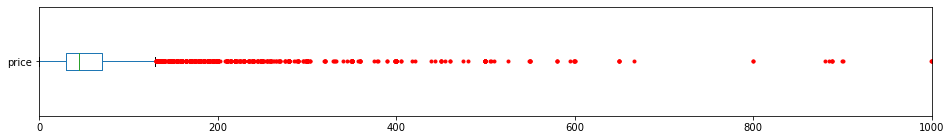

In [461]:
# Create boxplot 
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, 
                      flierprops=dict(markerfacecolor='r', markeredgecolor='r', marker='.'),
                      figsize=(16,2))

>The description of price shows that **75%** of the room only charged **within 70€**. But we can find the maximized price is extremely large - **up to 9000€**.

>To exclude the outlinear in this dataset, we set the data **limit of 600€**. 

>It also shows that data has **0 price**, that is not make sense. So we will exclude it too. 


In [462]:
df_short = df[(df['price'] <= 600) & (df['price'] > 0)]
df_short['price'].describe()

count    22488.000000
mean        58.521789
std         46.902846
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        600.000000
Name: price, dtype: float64

In [463]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_short.shape))

The dataset has 22488 rows and 32 columns - after being price-wise preprocessed.


#### b, deal with missing values of features

In [464]:
# checking Nan's in all columns
df_short.isna().sum(axis = 0)

host_id                            0
host_is_superhost                 25
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
latitude                           0
                                ... 
cancellation_policy                0
cleaning_fee                    7103
extra_people                       0
security_deposit                9338
price                              0
Length: 32, dtype: int64

Fill in missing value of numerical data by mean.

In [465]:
columns_na = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
              'reviews_per_month']

for col in columns_na:
    df_short[col].fillna(value=df_short[col].mean(), inplace=True)

Cleaning Price related Columns and fill in missing value by '0.00'

In [466]:
for col in ['cleaning_fee', 'extra_people', 'security_deposit']:
    df_short[col] = df_short[col].str.replace('$', '').str.replace(',', '').astype(float)
    df_short[col].fillna(0, inplace=True)


Fill in missing value of bool data. 

In [467]:
# host_is_superhost
df_short['host_is_superhost'].replace({"t": 1, "f": 0}, inplace=True)
df_short['host_is_superhost'].fillna(value=0, inplace=True)

In [468]:
df_short['host_is_superhost'][0:5]

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: host_is_superhost, dtype: float64

In [469]:
df_short.isnull().sum(axis = 0)

host_id                         0
host_is_superhost               0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
                               ..
cancellation_policy             0
cleaning_fee                    0
extra_people                    0
security_deposit                0
price                           0
Length: 32, dtype: int64

## 3. perform Exploratory Data Analysis (EDA)

#### a. Location vs Price

Price Differences on a Map: <br> 
We can find Price increase when location is more close to center.

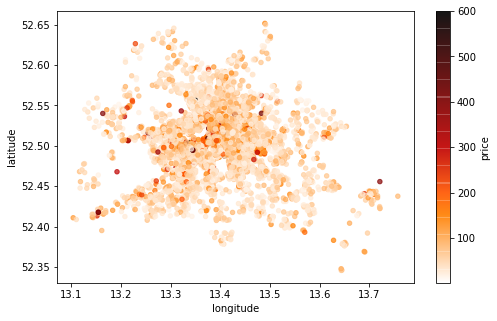

In [470]:
df_short.plot(kind="scatter", x="longitude", y="latitude", alpha=0.7, figsize=(8,5), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

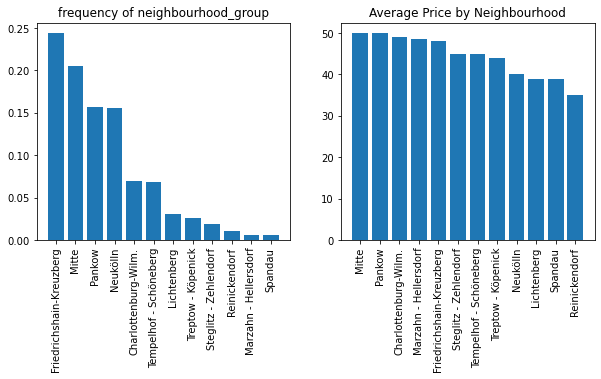

In [471]:
# count the frequency and average price of neighbourhood
plt.figure(figsize=(10,4))

count = df_short.neighbourhood_group_cleansed.value_counts(normalize = True)
df1 = pd.DataFrame(count).reset_index()

group = df_short.groupby('neighbourhood_group_cleansed')['price'].agg(np.median)
df2 = pd.DataFrame(group).reset_index().sort_values(['price'], ascending=False)

plt.subplot(1, 2, 1)
plt.bar(df1['index'],df1['neighbourhood_group_cleansed'])
plt.xticks(rotation=90)
plt.title('frequency of neighbourhood_group')

plt.subplot(1, 2, 2)
plt.bar(df2['neighbourhood_group_cleansed'],df2['price'])
plt.xticks(rotation=90)
plt.title('Average Price by Neighbourhood')
plt.show()

The result shows that around 45% of airbnb room located in **Friedrichshain-Kreuzberg** and **Mitte**. The median price of **Mitte** and **Pankow** are higher. 

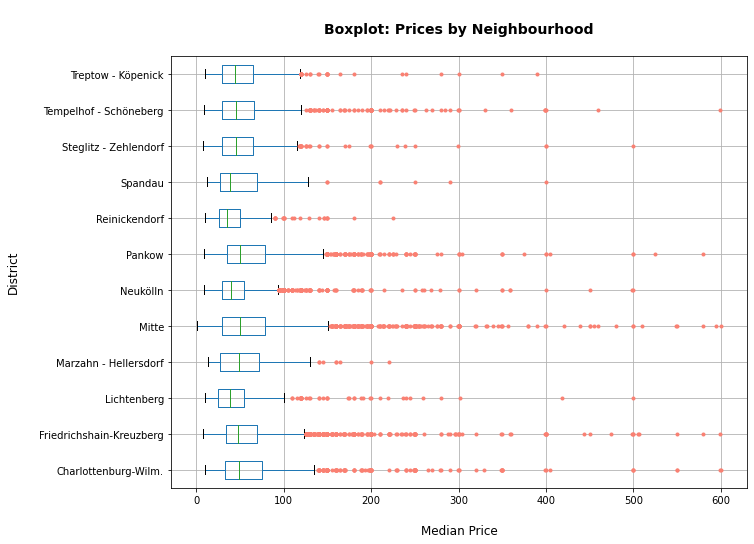

In [472]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df_short.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')
plt.suptitle(''); # get rid of automatic boxplot title

#### b. room and property type vs Price

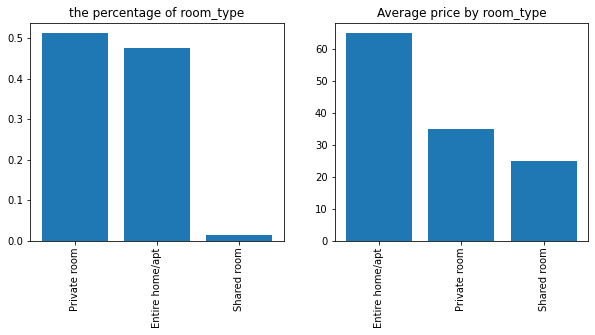

In [473]:
# count the frequency and average price of room_type
plt.figure(figsize=(10,4))

count = df.room_type.value_counts(normalize = True)
df1 = pd.DataFrame(count).reset_index()

group = df_short.groupby('room_type')['price'].agg(np.median)
df2 = pd.DataFrame(group).reset_index().sort_values(['price'], ascending=False)

plt.subplot(1, 2, 1)
plt.bar(df1['index'],df1['room_type'])
plt.xticks(rotation=90)
plt.title('the percentage of room_type')

plt.subplot(1, 2, 2)
plt.bar(df2['room_type'],df2['price'])
plt.xticks(rotation=90)
plt.title('Average price by room_type')
plt.show()

Half of the room is Private room, and another half of the room is Entire home/apt. **Entire home/apt** has the highest median price.

In [474]:
df.property_type.value_counts(normalize=True)

Apartment             0.896816
Condominium           0.027137
Loft                  0.020397
House                 0.017648
Serviced apartment    0.007760
                        ...   
In-law                0.000044
Tipi                  0.000044
Chalet                0.000044
Island                0.000044
Barn                  0.000044
Name: property_type, Length: 33, dtype: float64

In [475]:
group = df_short.groupby('property_type')['price'].agg(np.median)
df3 = pd.DataFrame(group).reset_index().sort_values(['price'], ascending=False)

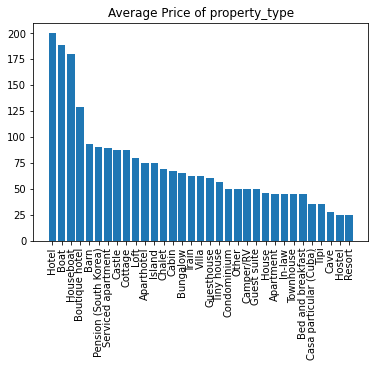

In [476]:
plt.bar(df3['property_type'],df3['price'])
plt.xticks(rotation=90)
plt.title('Average Price of property_type')
plt.show()

#### c. Price Differences on a minimum_nights, number_of_reviews, reviews_per_month, and availability_365

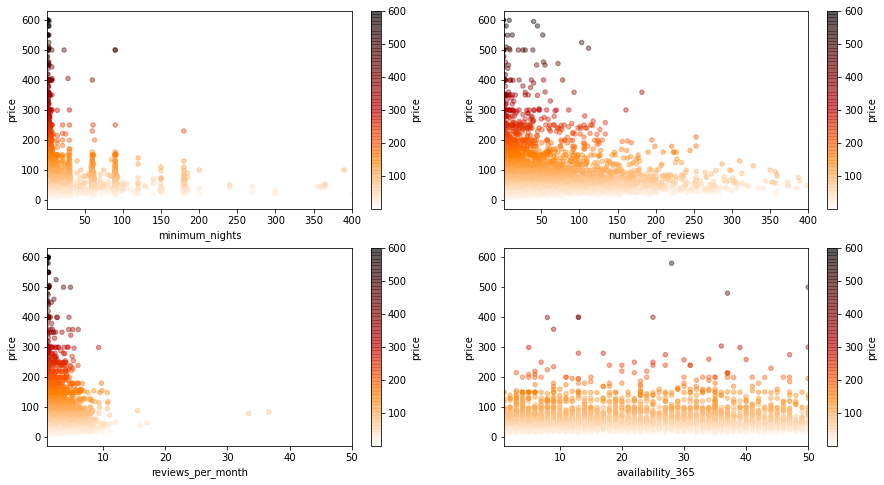

In [477]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df_short.plot(kind="scatter", x="minimum_nights", y="price", xlim = (1, 400), alpha=0.4, figsize=(15,8), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False, ax=axes[0,0])
df_short.plot(kind="scatter", x="number_of_reviews", y="price", xlim = (1, 400), alpha=0.4, figsize=(15,8), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False, ax=axes[0,1])
df_short.plot(kind="scatter", x="reviews_per_month", y="price", xlim = (1, 50), alpha=0.4, figsize=(15,8), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False,  ax=axes[1,0])
df_short.plot(kind="scatter", x="availability_365", y="price",  xlim = (1, 50), alpha=0.4, figsize=(15,8), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False, ax=axes[1,1])

Minimum_nights, number_of_reviews and reviews_per_month show negative corelation with price. <br>
Availability_365 shows no corelation with price. 

#### d. Correlations between reviews

In [478]:
col_review = ['review_scores_rating','review_scores_accuracy', 
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
            'review_scores_value']

In [479]:
cor = df[col_review].corr()

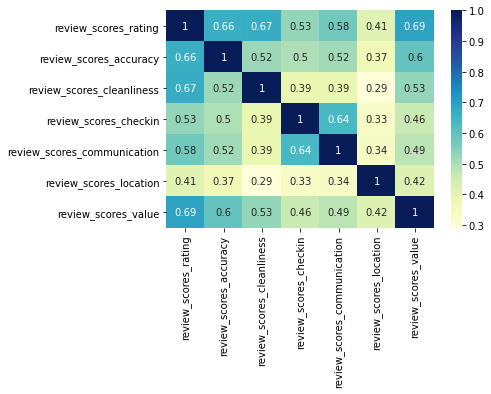

In [480]:
sns.heatmap(cor, cmap="YlGnBu", annot=True)

The correlation between reviews is high (0.39~0.69), so we only use one as representative. 

## 4. Data Preprocessing on features

#### a. Transfer 'latitude' and 'longitude' to the 'distance' from center

In [481]:
from geopy.distance import great_circle

In [482]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [483]:
df['distance'] = df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [484]:
df['distance']

0        3.533182
1        5.085573
2        3.695677
3        3.755285
4        4.550423
           ...   
22547    3.464543
22548    4.288544
22549    3.270333
22550    2.643811
22551    3.506518
Name: distance, Length: 22552, dtype: float64

#### b. Transfer data "amenities"

Count the number of amenities of each host

In [485]:
# amenities
df_short['amenities'][0:5]

0    {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
1    {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
2    {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
3    {Internet,Wifi,"Pets allowed","Pets live on th...
4    {Wifi,Heating,"Family/kid friendly",Essentials...
Name: amenities, dtype: object

In [486]:
fcn = lambda x : len(x.replace('{', '').replace('}', '').split(','))
df_short['amenities'] = df_short['amenities'].apply(fcn)

In [487]:
df_short['amenities'][0:5]

0    29
1    10
2    19
3    29
4    13
Name: amenities, dtype: int64

#### c. Transfer 'interaction', and 'instant_bookable' data into bool (0 or 1). 

In [488]:
# interaction
df_short['interaction'] = df_short['interaction'].isnull().astype(int)
df_short['instant_bookable'] = df_short['instant_bookable'].isnull().astype(int)

#### d. drop the columns that is not helpful for prediction

In [489]:
df_short.drop(['host_id', 'latitude', 'longitude', 'availability_365', 'neighbourhood_cleansed', 
               'neighbourhood_group_cleansed','review_scores_accuracy', 'review_scores_cleanliness', 
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], 
              axis=1, inplace=True) 

#### e. convert all string columns into categorical or numerical data 

convert oject data into category

In [490]:
categorical = ['room_type', 'property_type', 'cancellation_policy']
for col in categorical:
    df_short[col] = df_short[col].astype('category')

convert numerical data into integer 

In [491]:
col_num = [ 'accommodates', 'bathrooms', 'bedrooms', 'beds','review_scores_rating']

for col in col_num:
    df_short[col] = df_short[col].astype('int64')

In [492]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22488 entries, 0 to 22551
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   host_is_superhost     22488 non-null  float64 
 1   room_type             22488 non-null  category
 2   property_type         22488 non-null  category
 3   accommodates          22488 non-null  int64   
 4   bathrooms             22488 non-null  int64   
 5   bedrooms              22488 non-null  int64   
 6   beds                  22488 non-null  int64   
 7   amenities             22488 non-null  int64   
 8   review_scores_rating  22488 non-null  int64   
 9   guests_included       22488 non-null  int64   
 10  minimum_nights        22488 non-null  int64   
 11  number_of_reviews     22488 non-null  int64   
 12  reviews_per_month     22488 non-null  float64 
 13  interaction           22488 non-null  int32   
 14  instant_bookable      22488 non-null  int32   
 15  ca

#### f. One-hot encoding on categorical features

In [493]:
# define our target
target = df_short[["price"]]

# define our features 
features = df_short.drop(["price"], axis=1)

In [494]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'int32']).copy()

In [495]:
# # one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [496]:
# concate features together
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [497]:
print(features_recoded.shape)
features_recoded.head(5)

(22488, 57)


,host_is_superhost,accommodates,bathrooms,bedrooms,beds,amenities,review_scores_rating,guests_included,minimum_nights,number_of_reviews,...,property_type_Tiny house,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Villa,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1.0,3,1,1,2,29,93,1,4,118,...,0,0,0,0,0,0,0,1,0,0
1,0.0,2,1,1,1,10,100,1,2,6,...,0,0,0,0,0,1,0,0,0,0
2,0.0,4,1,1,2,19,92,2,62,143,...,0,0,0,0,0,0,0,1,0,0
3,0.0,2,1,1,1,29,88,1,5,25,...,0,0,0,0,0,0,0,1,0,0
4,1.0,2,1,1,2,13,96,1,2,197,...,0,0,0,0,0,0,1,0,0,0


## 5. Build ML Models 

In [498]:
from sklearn.model_selection import train_test_split

In [499]:
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target)

#### a. Linear Regression 

In [500]:
from sklearn.linear_model import LinearRegression

In [501]:
# Mulitple linear regression

model = LinearRegression()
model.fit(X_train, y_train)

r_square = model.score(X_test, y_test)
print('"Test set R^2:{:.5f}'.format(r_square))

"Test set R^2:0.37046


#### b. Random Forest

In [502]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [503]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)

RandomForestRegressor()

In [504]:
all_accuracies = cross_val_score(estimator=rfc, X=X_train, y=y_train, cv=5)
np.mean(all_accuracies)

0.5170776889646225

In [435]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[0:20, ]

    #Define size of bar plot
    plt.figure(figsize=(10,8))

    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

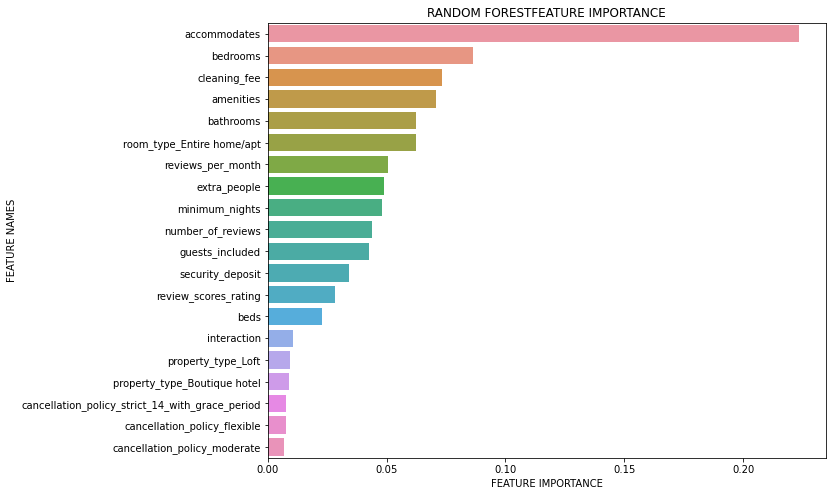

In [436]:
names = list(features_recoded.columns)
plot_feature_importance(rfc.feature_importances_, names, 'RANDOM FOREST')

#### c. XGBoost Regressor

https://www.kaggle.com/brittabettendorf/predicting-prices-xgboost-feature-engineering

In [437]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [439]:
import xgboost as xgb

In [440]:
# create a baseline
booster = xgb.XGBRegressor()

In [442]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=4, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


In [443]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, 
                           max_depth=6, n_estimators=200)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [448]:
from sklearn.metrics import mean_squared_error, r2_score

In [446]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 30.8323


In [449]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.5622


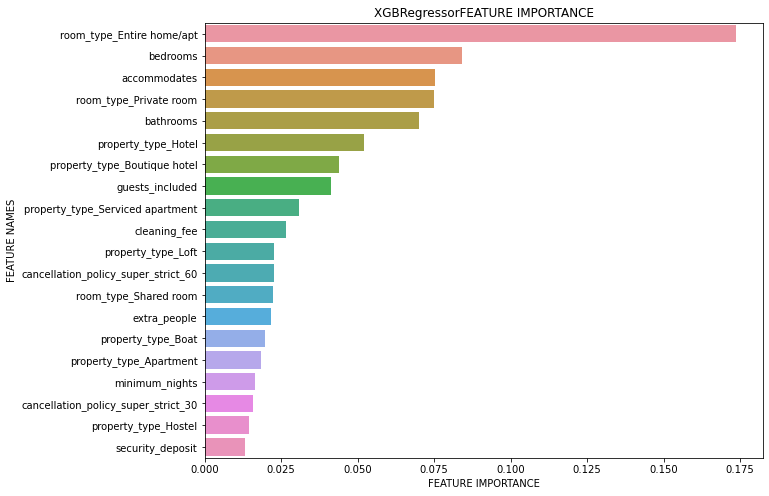

In [453]:
names = list(features_recoded.columns)
plot_feature_importance(booster.feature_importances_, names, 'XGBRegressor')